In [35]:
import pandas as pd
import math
from functools import reduce
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
pd.set_option('chained_assignment',None)
from matplotlib.backends.backend_pdf import PdfPages

In [36]:
main_df = pd.read_excel('C:/Users/lzoeckler/Desktop/decay/DBS_stability_2.xlsx')
main_df.rename(columns={'Unnamed: 0': 'analyte', 'Unnamed: 1': 'treatment_condition',
                       'Unnamed: 2': 'time_or_humidity'}, inplace=True)
main_df.loc[main_df['analyte'] == 'Pv LDH', 'analyte'] = 'Pv_LDH'
main_df.loc[main_df['analyte'] == 'Pf LDH', 'analyte'] = 'Pf_LDH'
main_df.head()

,analyte,treatment_condition,time_or_humidity,Hi,Med,Low
0,HRP2,-20oC,1.0,1546.99,806.53,79.33
1,HRP2,-20oC,3.0,1300.62,791.51,64.99
2,HRP2,-20oC,7.0,1582.84,897.24,88.90
3,HRP2,-20oC,15.0,1547.39,691.08,67.17
4,HRP2,-20oC,30.0,1648.93,927.27,93.60


In [37]:
main_df['analyte'].unique()

array(['HRP2', 'Pv_LDH', 'Pf_LDH', 'CRP'], dtype=object)

In [38]:
def temp_adjust(df):
    temp = df['treatment_condition']
    temp = temp.replace("oC", "")
    temp = int(temp)
    return temp

In [39]:
time_df = main_df.loc[main_df['treatment_condition'] != 'Humidity']
time_df['treatment_condition'] = time_df.apply(temp_adjust, axis=1)
time_df['treatment_condition'].unique()

array([-20,   4,  23,  30,  50], dtype=int64)

In [40]:
time_df['time_or_humidity'].unique()

array([  1.,   3.,   7.,  15.,  30.,  60., 120., 240.])

In [41]:
time_df.loc[(time_df['treatment_condition'] == 4)
            & (time_df['analyte'] == 'Pf_LDH')]

,analyte,treatment_condition,time_or_humidity,Hi,Med,Low
48,Pf_LDH,4,1.0,14046.28,8512.34,699.70
49,Pf_LDH,4,3.0,10830.68,6827.24,733.67
50,Pf_LDH,4,7.0,12851.85,6780.80,1020.71
51,Pf_LDH,4,15.0,10828.34,6620.00,717.24
52,Pf_LDH,4,30.0,11073.76,7259.36,726.47
53,Pf_LDH,4,60.0,9051.57,6087.39,734.50
54,Pf_LDH,4,120.0,10267.39,5463.79,567.97
55,Pf_LDH,4,240.0,8830.77,5670.04,642.13


In [42]:
base_value_df = time_df.loc[time_df['treatment_condition'] == -20]
base_value_df = base_value_df.groupby(['analyte', 'treatment_condition']).mean().reset_index()
base_value_df.drop(['treatment_condition', 'time_or_humidity'], axis=1, inplace=True)
base_value_df

,analyte,Hi,Med,Low
0,CRP,17950.92500,7628.23500,699.82500
1,HRP2,1534.43625,825.94375,83.70375
2,Pf_LDH,12022.15500,6948.41500,796.22750
3,Pv_LDH,4976.20875,2897.74000,312.14625


In [43]:
time_df = time_df.loc[time_df['treatment_condition'] != -20]
time_df = time_df.merge(base_value_df, on='analyte', suffixes=('', '_base'))
time_df.head()

,analyte,treatment_condition,time_or_humidity,Hi,Med,Low,Hi_base,Med_base,Low_base
0,HRP2,4,1.0,1937.11,1006.40,79.08,1534.43625,825.94375,83.70375
1,HRP2,4,3.0,1438.96,875.57,76.59,1534.43625,825.94375,83.70375
2,HRP2,4,7.0,1748.31,945.54,105.97,1534.43625,825.94375,83.70375
3,HRP2,4,15.0,1563.24,809.20,73.14,1534.43625,825.94375,83.70375
4,HRP2,4,30.0,1716.19,1039.20,222.44,1534.43625,825.94375,83.70375


C:\Users\lzoeckler\miniconda3\envs\DIAMETER\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\lzoeckler\miniconda3\envs\DIAMETER\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\lzoeckler\miniconda3\envs\DIAMETER\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

C:\Users\lzoeckler\miniconda3\envs\DIAMETER\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


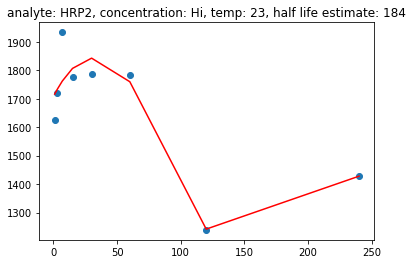

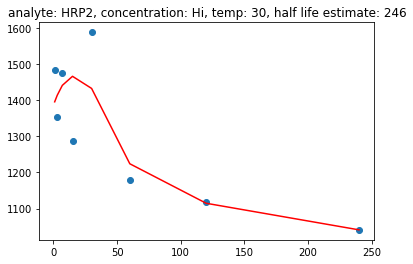

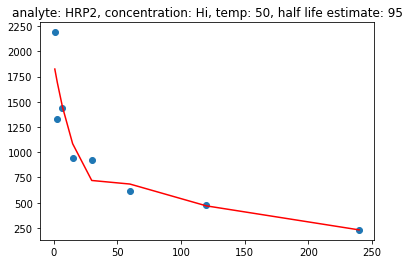

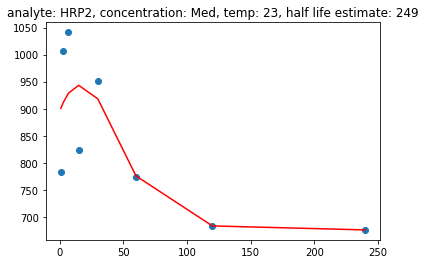

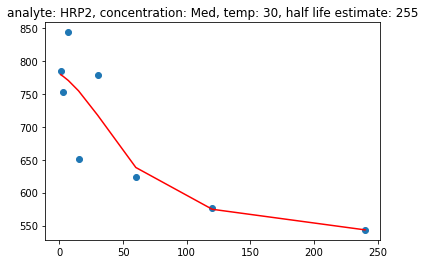

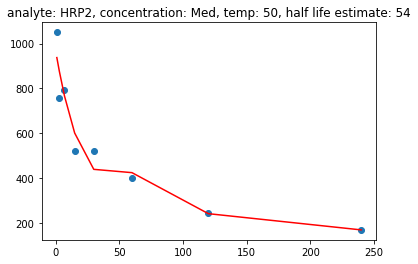

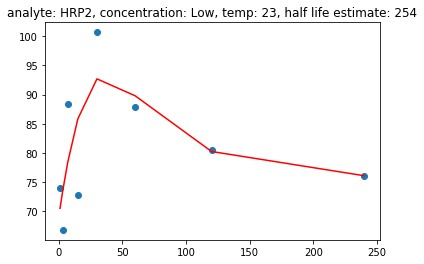

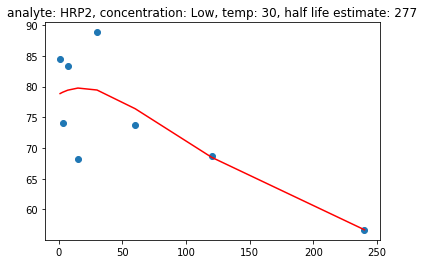

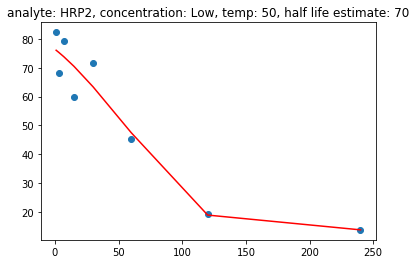

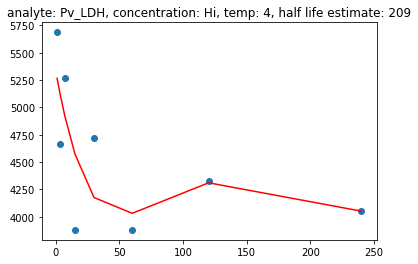

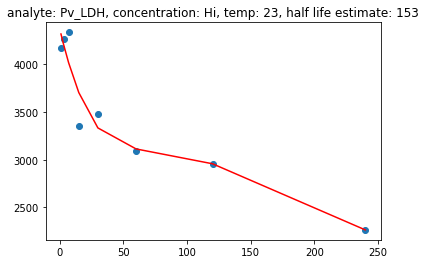

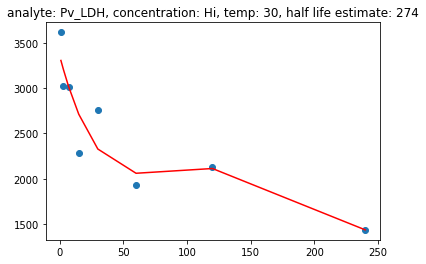

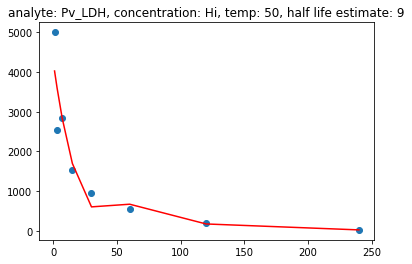

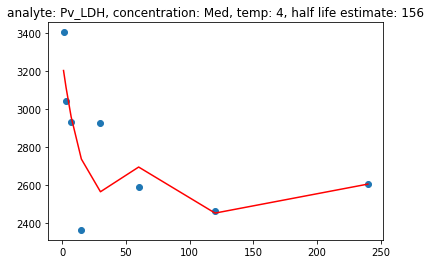

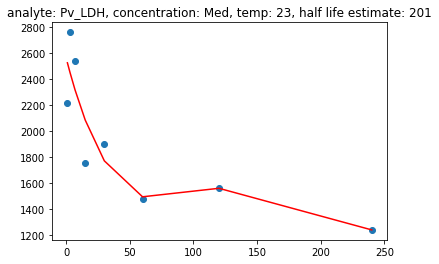

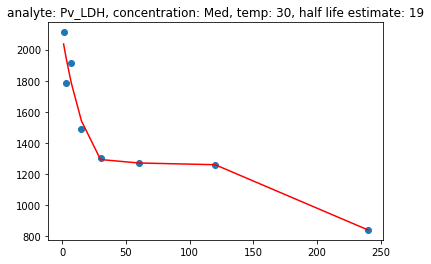

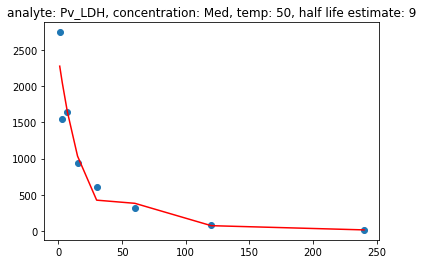

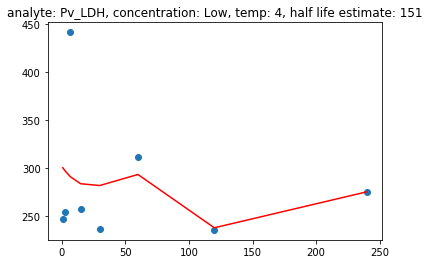

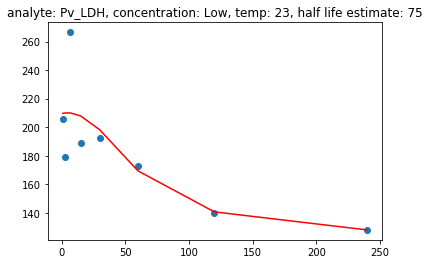

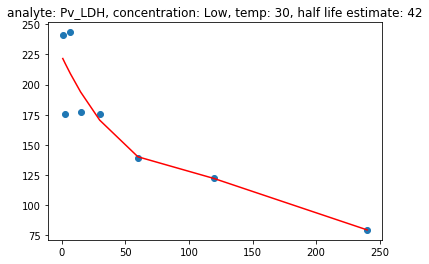

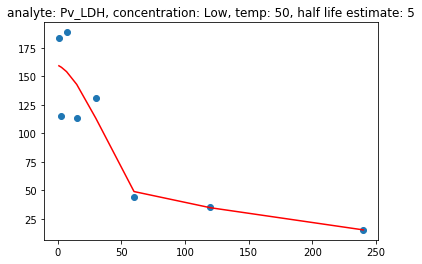

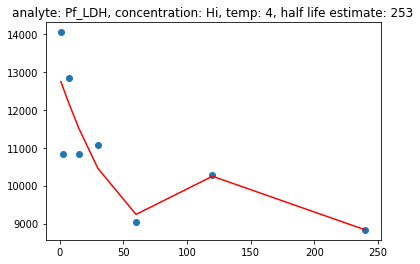

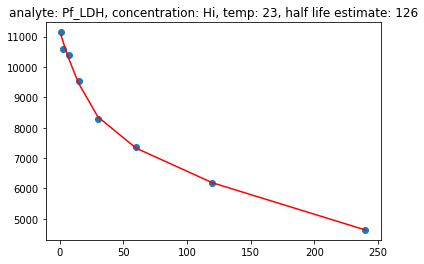

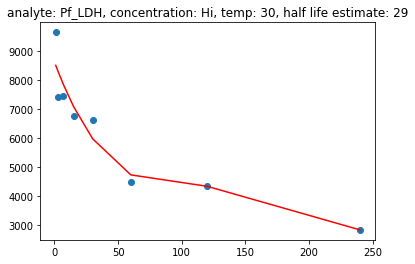

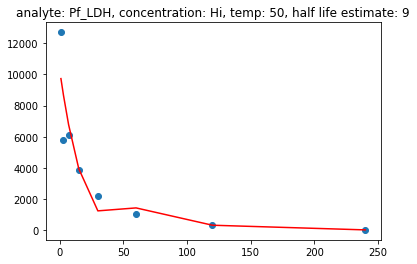

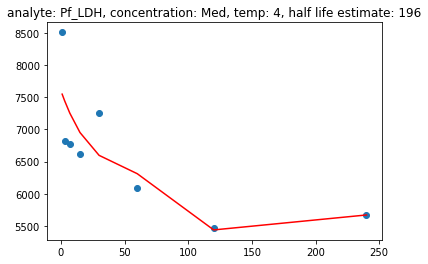

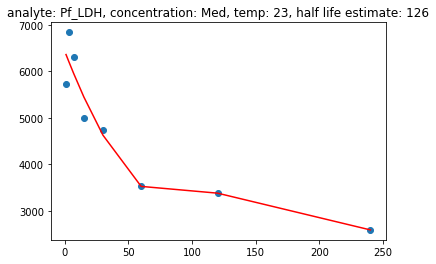

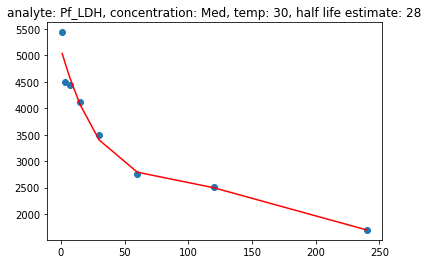

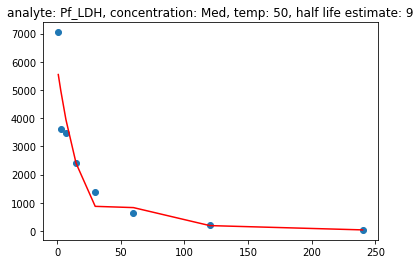

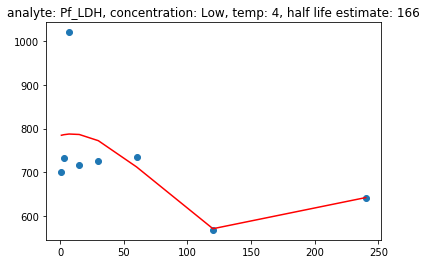

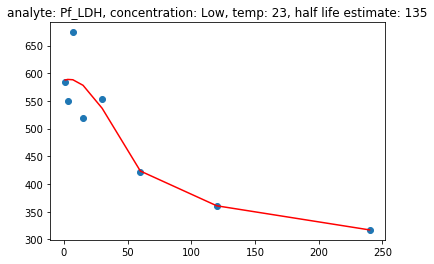

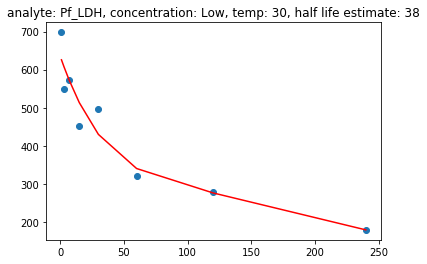

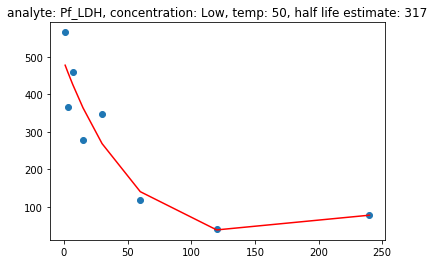

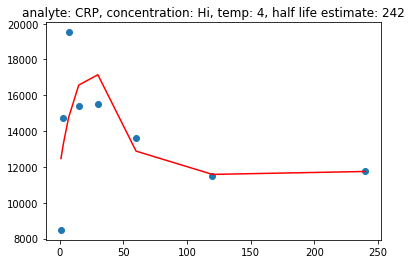

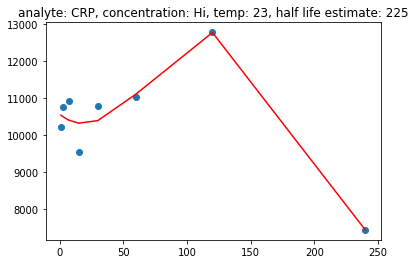

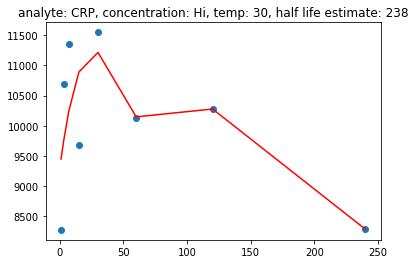

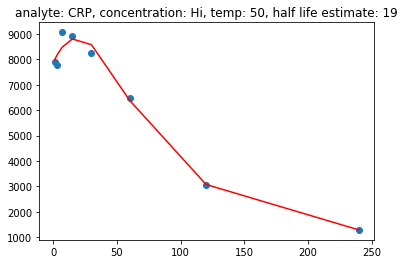

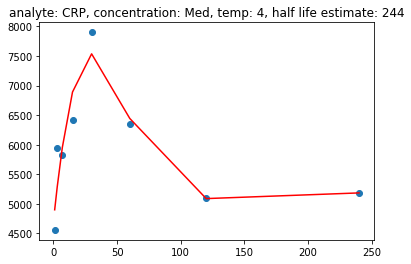

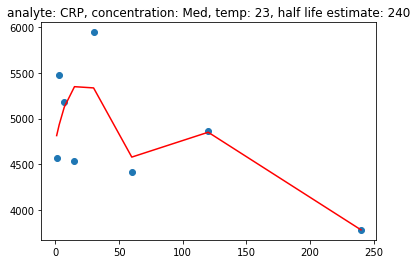

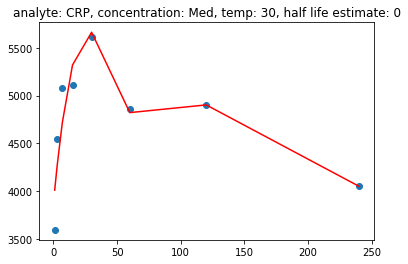

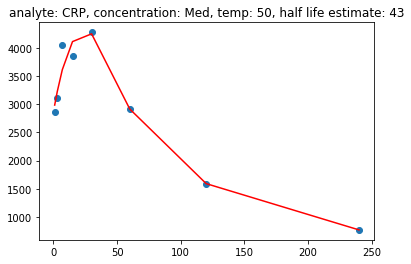

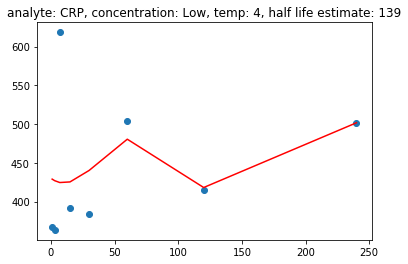

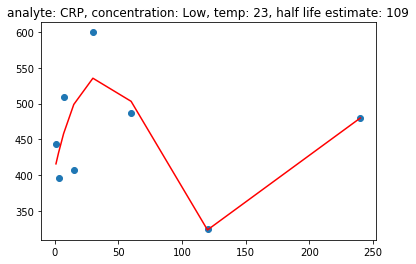

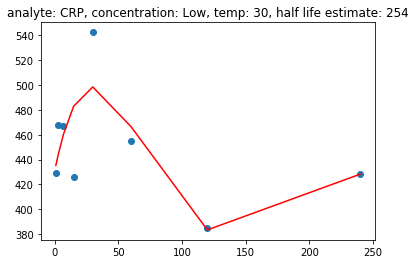

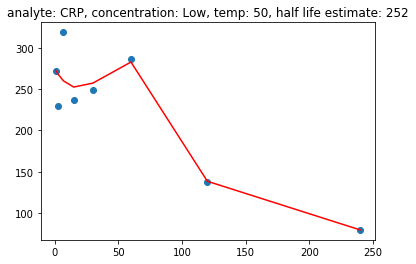

In [45]:
test_df = time_df.copy(deep=True)
#test_df = test_df.loc[test_df['time_or_humidity'] > 15]
pp = PdfPages('foo.pdf')
for analyte in time_df['analyte'].unique():
    an_df = test_df.loc[time_df['analyte'] == analyte]
    for concentration in ['Hi', 'Med', 'Low']:
        con_df = an_df[['treatment_condition', 'time_or_humidity',
                        concentration, '{}_base'.format(concentration)]]
        end_df = con_df.loc[con_df['time_or_humidity'] == 240.0]
        end_df['decay'] = True
        end_df.loc[end_df[concentration] > end_df['{}_base'.format(concentration)], 'decay'] = False
        end_df.drop(['time_or_humidity', concentration, '{}_base'.format(concentration)], axis=1, inplace=True)
        con_df = con_df.merge(end_df, on=['treatment_condition'])
        calc_df = con_df.loc[con_df['decay'] == True]
        base_val = calc_df['{}_base'.format(concentration)].tolist()[0]
        for temp in calc_df['treatment_condition'].unique():
            temp_df = calc_df.loc[calc_df['treatment_condition'] == temp]
            temp_df.drop(['decay', 'treatment_condition', '{}_base'.format(concentration)], axis=1, inplace=True)
            poly = PolynomialFeatures(degree=4)
            regr = linear_model.LinearRegression()
            time = temp_df['time_or_humidity'].values.reshape(-1,1)
            con = temp_df[concentration].values.reshape(-1,1)
            poly_time = poly.fit_transform(time)
            regr.fit(poly_time, con)
            pred = regr.predict(poly_time)
            closest_difference = 1000000000
            close_time = 'FAIL'
            best_half = 'FAIL'
            for value in range(0, 400):
                guess = regr.predict(poly.fit_transform([[value]]))
                difference = abs((base_val / 2) - guess)
                if difference < closest_difference:
                    closest_difference = difference
                    close_time = value
                    best_half = guess
            f = plt.figure()
            plt.scatter(time, con)
            plt.plot(time, pred, color='red')
            title = "analyte: {}, concentration: {}, temp: {}, half life estimate: {}".format(
                analyte, concentration, temp, close_time)
            plt.title(title)
            pp.savefig(f)
pp.close()

In [37]:
regr.predict(poly.fit_transform([[301]]))

array([[41.94337935]])

In [38]:
base_val / 2

41.851875